In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [123]:
from torchinfo import summary
from sklearn.metrics import confusion_matrix

In [4]:
import rarfile
import shutil

In [8]:
rarfile.UNRAR_TOOL = r"C:\Program Files\WinRAR\UnRAR.exe"

### Dataset

In [9]:
rar_path = '10973_2021_10903_MOESM2_ESM.rar'
extract_to_folder = 'burning_liquid_dataset'
os.makedirs(extract_to_folder, exist_ok=True)

with rarfile.RarFile(rar_path) as rf:
    # List all files in the .rar archive
    all_files = rf.infolist()
    image_files = [f.filename for f in all_files if f.filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    print(f"Found {len(image_files)} image files.")
    #print(image_files)
    batch_size = 500  # Adjust based on your preference
    num_batches = (len(image_files) + batch_size - 1) // batch_size  # Calculate the number of batches
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(image_files))
        batch_files = image_files[start_idx:end_idx]
        for file in batch_files:
            #print(file)
        # Extract each batch
            rf.extract(file, extract_to_folder)
        print(f"Extracted batch {batch_idx + 1} out of {num_batches}")

print(f"Extraction completed to {extract_to_folder}")

Found 3000 image files.
Extracted batch 1 out of 6
Extracted batch 2 out of 6
Extracted batch 3 out of 6
Extracted batch 4 out of 6
Extracted batch 5 out of 6
Extracted batch 6 out of 6
Extraction completed to burning_liquid_dataset


### (a) Splitting to subfolders

In [10]:
source_folder = r'burning_liquid_dataset\S1_Raw_Photographs_Full_Study'
root_folder = 'burning_liquid_classes'
classes = set(filename.split('_')[0] for filename in os.listdir(source_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')))
print(classes)

{'Ethanol', 'Pentane', 'Propanol'}


In [22]:
os.makedirs(root_folder, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(root_folder, class_name), exist_ok=True)

for filename in os.listdir(source_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Image file extensions
        class_name = filename.split('_')[0]
        if class_name in classes: 
            # Construct the full path to move the image
            src_image_path = os.path.join(source_folder, filename)
            dest_image_path = os.path.join(root_folder, class_name, filename)
    
            # Move the image to the corresponding class folder
            shutil.move(src_image_path, dest_image_path)

print("Images have been successfully organized into class subfolders.")

Images have been successfully organized into class subfolders.


### (b) Splitting into training, testing & validation datasets
### (c) Use transformation & normalize image 

In [190]:
image_dataset = datasets.ImageFolder(root=root_folder)
print(f"Total Number of samples: {len(image_dataset)}")

Total Number of samples: 3000


In [191]:
full_dataset_size = len(image_dataset)
train_percent, val_percent = 0.7, 0.2
num_train_samples = int(train_percent*full_dataset_size)
num_val_samples = int(val_percent*full_dataset_size)
num_test_samples = full_dataset_size - num_train_samples - num_val_samples
print("Number of training samples", num_train_samples)
print("Number of validation samples", num_val_samples)
print("Number of testing samples", num_test_samples)

Number of training samples 2100
Number of validation samples 600
Number of testing samples 300


In [193]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # Data augmentation (only applied to training data)
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=15),  # Random rotation up to ±15 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random scaling and cropping
    # Contrast enhancement
    transforms.ColorJitter(contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for validation & testing
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization
])

In [194]:
# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(image_dataset, [num_train_samples, num_val_samples, num_test_samples])

train_dataset.dataset.transform = train_transform  # Apply train_transform to the whole train dataset
val_dataset.dataset.transform = val_test_transform  # Apply val_test_transform to the validation dataset
test_dataset.dataset.transform = val_test_transform  # Apply the same transform to the test dataset


# Create DataLoaders for each subset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 2100, Validation size: 600, Test size: 300


In [195]:
training_data = iter(train_loader)
train_batch_imgs, train_batch_labels = next(training_data)
print(f"Number of batches in training data: {len(training_data)}")
print(f"Image batch shape: {train_batch_imgs.shape}")
print(f"Labels batch shape: {train_batch_labels.size()}")
imgi = train_batch_imgs[0]#.squeeze()
labeli = train_batch_labels[0]
print(f"Label: {labeli}")
print("Shape of ith image is:", imgi.shape)
print("Shape of ith label is:", labeli.shape)
#plt.imshow(imgi.view(28,28))
#plt.show()

Number of batches in training data: 66
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Label: 2
Shape of ith image is: torch.Size([3, 224, 224])
Shape of ith label is: torch.Size([])


In [196]:
print(imgi.unsqueeze(0).shape)

torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


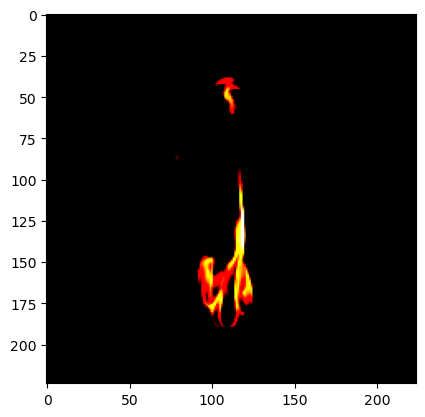

In [197]:
plt.imshow(imgi.permute(1,2,0))
plt.show()

### Model - Load the pre-trained ResNet model except the last layer (i.e the classification layer)

In [198]:
from torchvision.models import resnet34

In [199]:
num_classes = len(classes)
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [200]:
all_layers = []
for name, module in model.named_children():
    print(name, ":", type(module))
    if name.startswith('layer'):
        all_layers.append(name)

conv1 : <class 'torch.nn.modules.conv.Conv2d'>
bn1 : <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu : <class 'torch.nn.modules.activation.ReLU'>
maxpool : <class 'torch.nn.modules.pooling.MaxPool2d'>
layer1 : <class 'torch.nn.modules.container.Sequential'>
layer2 : <class 'torch.nn.modules.container.Sequential'>
layer3 : <class 'torch.nn.modules.container.Sequential'>
layer4 : <class 'torch.nn.modules.container.Sequential'>
avgpool : <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>
fc : <class 'torch.nn.modules.linear.Linear'>


In [201]:
print("List of all layers excluding the final layer:", all_layers)

List of all layers excluding the final layer: ['layer1', 'layer2', 'layer3', 'layer4']


### Training

In [202]:
import torch.optim as optim
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [203]:
def run_model(mymodel, optm, traindataloader, valdataloader, num_epochs):
    num_training_samples = len(traindataloader.dataset)
    num_training_batches = len(traindataloader)
    num_val_samples = len(valdataloader.dataset)
    num_val_batches = len(valdataloader)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]..........")
        mymodel.train()
        total_train_loss = 0
        train_correct = 0
        
        for images, labels in traindataloader:
            optm.zero_grad()
            train_outputs = mymodel(images)
            loss = criterion(train_outputs, labels)
            loss.backward()
            optm.step()
    
            total_train_loss += loss.item()
            _, train_preds = train_outputs.max(1)  # Get predicted class
            train_correct += train_preds.eq(labels).sum().item()
    
        train_loss = total_train_loss / num_training_batches
        train_accuracy = 100.0 * train_correct / num_training_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        
        model.eval()
        total_val_loss = 0.0
        val_correct = 0
    
        with torch.no_grad():
            for images, labels in valdataloader:                
                # Forward pass
                val_outputs = mymodel(images)
                loss = criterion(val_outputs, labels)
                # Update loss
                total_val_loss += loss.item()
                # Calculate accuracy
                _, val_preds = val_outputs.max(1)
                val_correct += val_preds.eq(labels).sum().item()
    
        val_loss = total_val_loss / num_val_batches
        val_accuracy = 100.0 * val_correct / num_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [218]:
def plot_metrics(max_iter, training_metric, test_or_val_metric, metric_type, test_or_val, text):
    """Plots the metrics"""
    axis = range(max_iter)
    precision = max_iter
    xlabel = 'Epochs'
    title = f'Training with {text}: '

    plt.figure(figsize=(10, 5))
    plt.plot(axis, training_metric, label=f'Training {metric_type}')
    plt.plot(axis, test_or_val_metric, label=f'{test_or_val} {metric_type}')
    plt.xlabel(xlabel)
    #plt.xticks(range(0, precision, precision//10))
    plt.ylabel(f'{metric_type}')
    plt.title(f'{title} {metric_type} for Training and {test_or_val} Set')
    plt.legend()
    plt.grid(True)
    plt.show()

### Case1: Training model with only the fully connected classification layer while freezing other layers

In [205]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [206]:
case1_train_losses, case1_train_accuracies, case1_val_losses, case1_val_accuracies = run_model(model, optimizer, train_loader, val_loader, 15)

Epoch [1/15]..........
Train Loss: 1.0220, Train Accuracy: 48.10%
Validation Loss: 0.8813, Validation Accuracy: 64.00%
Epoch [2/15]..........
Train Loss: 0.8051, Train Accuracy: 71.10%
Validation Loss: 0.7205, Validation Accuracy: 75.17%
Epoch [3/15]..........
Train Loss: 0.6682, Train Accuracy: 80.52%
Validation Loss: 0.6055, Validation Accuracy: 82.50%
Epoch [4/15]..........
Train Loss: 0.5717, Train Accuracy: 84.62%
Validation Loss: 0.5291, Validation Accuracy: 86.00%
Epoch [5/15]..........
Train Loss: 0.5075, Train Accuracy: 87.19%
Validation Loss: 0.4727, Validation Accuracy: 87.67%
Epoch [6/15]..........
Train Loss: 0.4647, Train Accuracy: 87.90%
Validation Loss: 0.4306, Validation Accuracy: 88.83%
Epoch [7/15]..........
Train Loss: 0.4354, Train Accuracy: 88.43%
Validation Loss: 0.4004, Validation Accuracy: 89.33%
Epoch [8/15]..........
Train Loss: 0.4019, Train Accuracy: 89.43%
Validation Loss: 0.3747, Validation Accuracy: 89.67%
Epoch [9/15]..........
Train Loss: 0.3877, Train

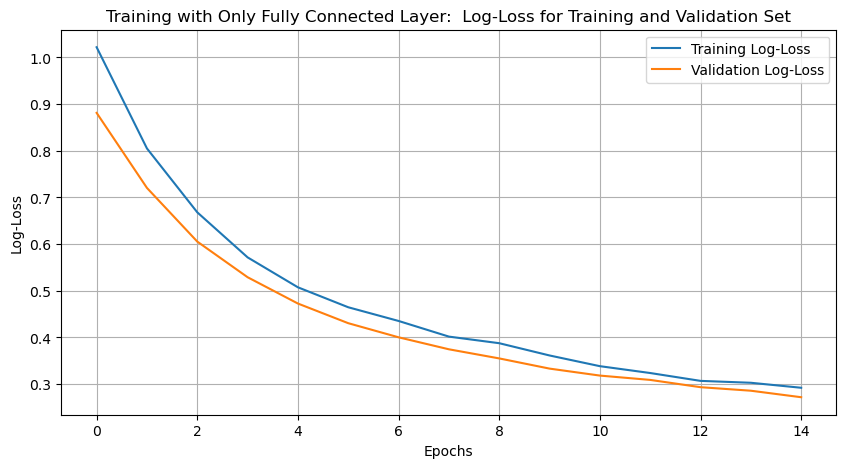

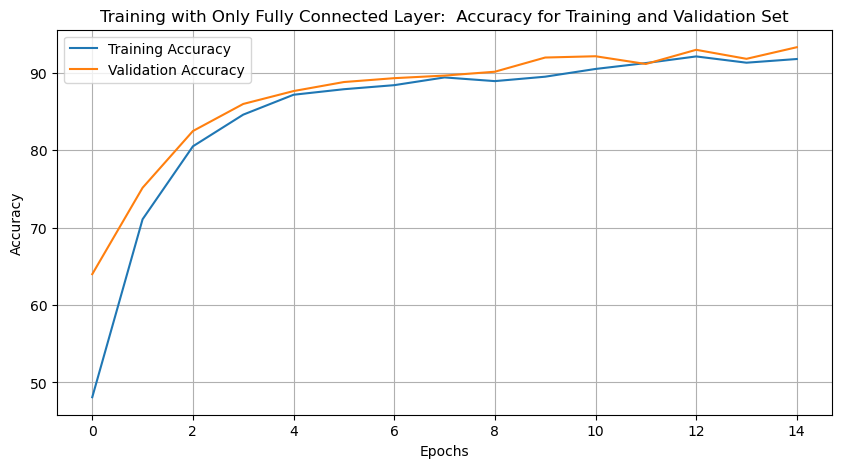

In [219]:
plot_metrics(15, case1_train_losses, case1_val_losses, 'Log-Loss', 'Validation', 'Only Fully Connected Layer')
plot_metrics(15, case1_train_accuracies, case1_val_accuracies, 'Accuracy', 'Validation', 'Only Fully Connected Layer')

### Case2: Training model by progressively unfreezing some layers

In [209]:
# Unfreeze the last block (layer4) of ResNet
def unfreeze_layers(mymodel, layers, num_unfreeze_layers):
    layers_to_unfreeze = layers[-num_unfreeze_layers:]
    # Freeze all layers initially
    for param in mymodel.parameters():
        param.requires_grad = False
    
    # Unfreeze the specified layers
    for layer_name in layers_to_unfreeze:
        layer = getattr(mymodel, layer_name, None)
        if layer is not None:  # Ensure the layer exists
            for param in layer.parameters():
                param.requires_grad = True
    
    # Unfreeze the fc layer
    for param in mymodel.fc.parameters():
        param.requires_grad = True
    
    # Print unfreezed layers for confirmation
    print("Unfrozen layers:")
    for name, param in mymodel.named_parameters():
        if param.requires_grad:
            print(name)
    # Update the optimizer to include the newly unfrozen parameters
    optim_l = optim.Adam(filter(lambda p: p.requires_grad, mymodel.parameters()), lr=1e-5)
    return mymodel, optim_l

In [210]:
model, optim_layer2 = unfreeze_layers(model, all_layers, 1)

Unfrozen layers:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
fc.weight
fc.bias


In [211]:
case2_train_losses, case2_train_accuracies, case2_val_losses, case2_val_accuracies = run_model(model, optim_layer2, train_loader, val_loader, 10)

Epoch [1/10]..........
Train Loss: 0.1669, Train Accuracy: 94.81%
Validation Loss: 0.0773, Validation Accuracy: 98.00%
Epoch [2/10]..........
Train Loss: 0.0681, Train Accuracy: 98.10%
Validation Loss: 0.0450, Validation Accuracy: 98.83%
Epoch [3/10]..........
Train Loss: 0.0380, Train Accuracy: 99.14%
Validation Loss: 0.0312, Validation Accuracy: 99.00%
Epoch [4/10]..........
Train Loss: 0.0270, Train Accuracy: 99.48%
Validation Loss: 0.0243, Validation Accuracy: 99.33%
Epoch [5/10]..........
Train Loss: 0.0145, Train Accuracy: 99.86%
Validation Loss: 0.0214, Validation Accuracy: 99.33%
Epoch [6/10]..........
Train Loss: 0.0094, Train Accuracy: 99.90%
Validation Loss: 0.0218, Validation Accuracy: 99.33%
Epoch [7/10]..........
Train Loss: 0.0085, Train Accuracy: 99.81%
Validation Loss: 0.0163, Validation Accuracy: 99.50%
Epoch [8/10]..........
Train Loss: 0.0051, Train Accuracy: 99.95%
Validation Loss: 0.0201, Validation Accuracy: 99.33%
Epoch [9/10]..........
Train Loss: 0.0043, Train

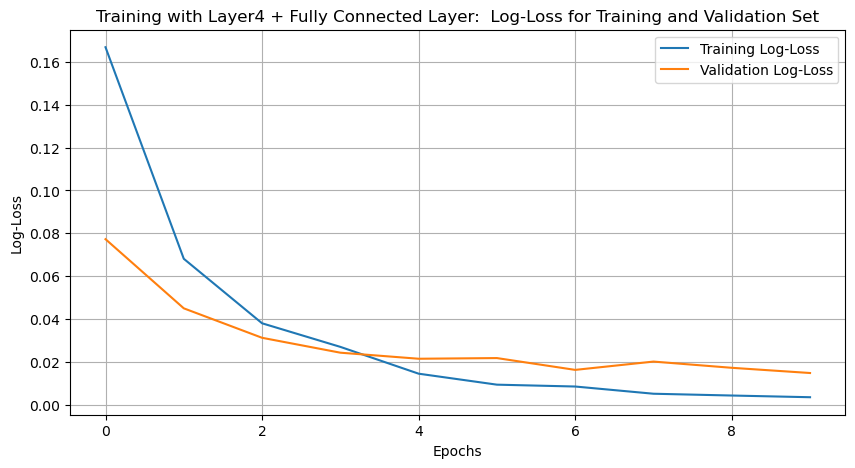

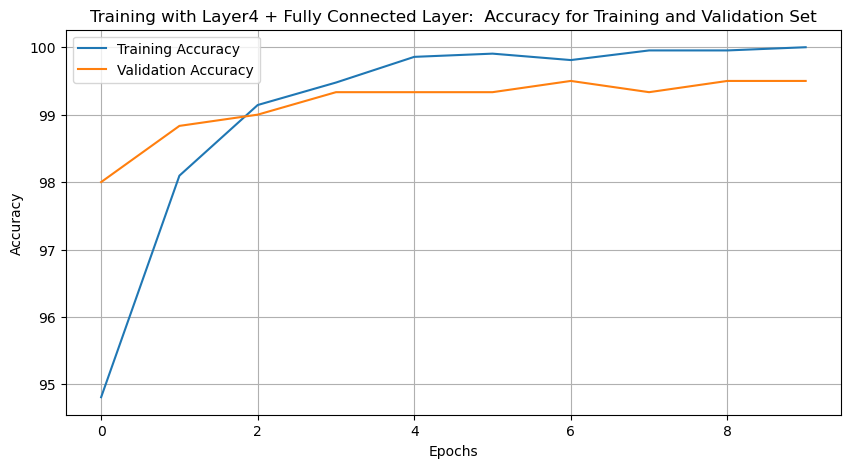

In [220]:
plot_metrics(10, case2_train_losses, case2_val_losses, 'Log-Loss', 'Validation', 'Layer4 + Fully Connected Layer')
plot_metrics(10, case2_train_accuracies, case2_val_accuracies, 'Accuracy', 'Validation', 'Layer4 + Fully Connected Layer')

### Case3: Unfreeze Layer4 , Layer3 & FC layer

In [215]:
model, _ = unfreeze_layers(model, all_layers, 2)

Unfrozen layers:
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer3.2.conv1.weight
layer3.2.bn1.weight
layer3.2.bn1.bias
layer3.2.conv2.weight
layer3.2.bn2.weight
layer3.2.bn2.bias
layer3.3.conv1.weight
layer3.3.bn1.weight
layer3.3.bn1.bias
layer3.3.conv2.weight
layer3.3.bn2.weight
layer3.3.bn2.bias
layer3.4.conv1.weight
layer3.4.bn1.weight
layer3.4.bn1.bias
layer3.4.conv2.weight
layer3.4.bn2.weight
layer3.4.bn2.bias
layer3.5.conv1.weight
layer3.5.bn1.weight
layer3.5.bn1.bias
layer3.5.conv2.weight
layer3.5.bn2.weight
layer3.5.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight


In [216]:
optim_all = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
case3_train_losses, case3_train_accuracies, case3_val_losses, case3_val_accuracies = run_model(model, optim_all, train_loader, val_loader, 3)

Epoch [1/3]..........
Train Loss: 0.0012, Train Accuracy: 100.00%
Validation Loss: 0.0088, Validation Accuracy: 99.50%
Epoch [2/3]..........
Train Loss: 0.0006, Train Accuracy: 100.00%
Validation Loss: 0.0094, Validation Accuracy: 99.50%
Epoch [3/3]..........
Train Loss: 0.0008, Train Accuracy: 100.00%
Validation Loss: 0.0082, Validation Accuracy: 99.50%


### Layer Visualization

Output shape: torch.Size([1, 64, 112, 112])


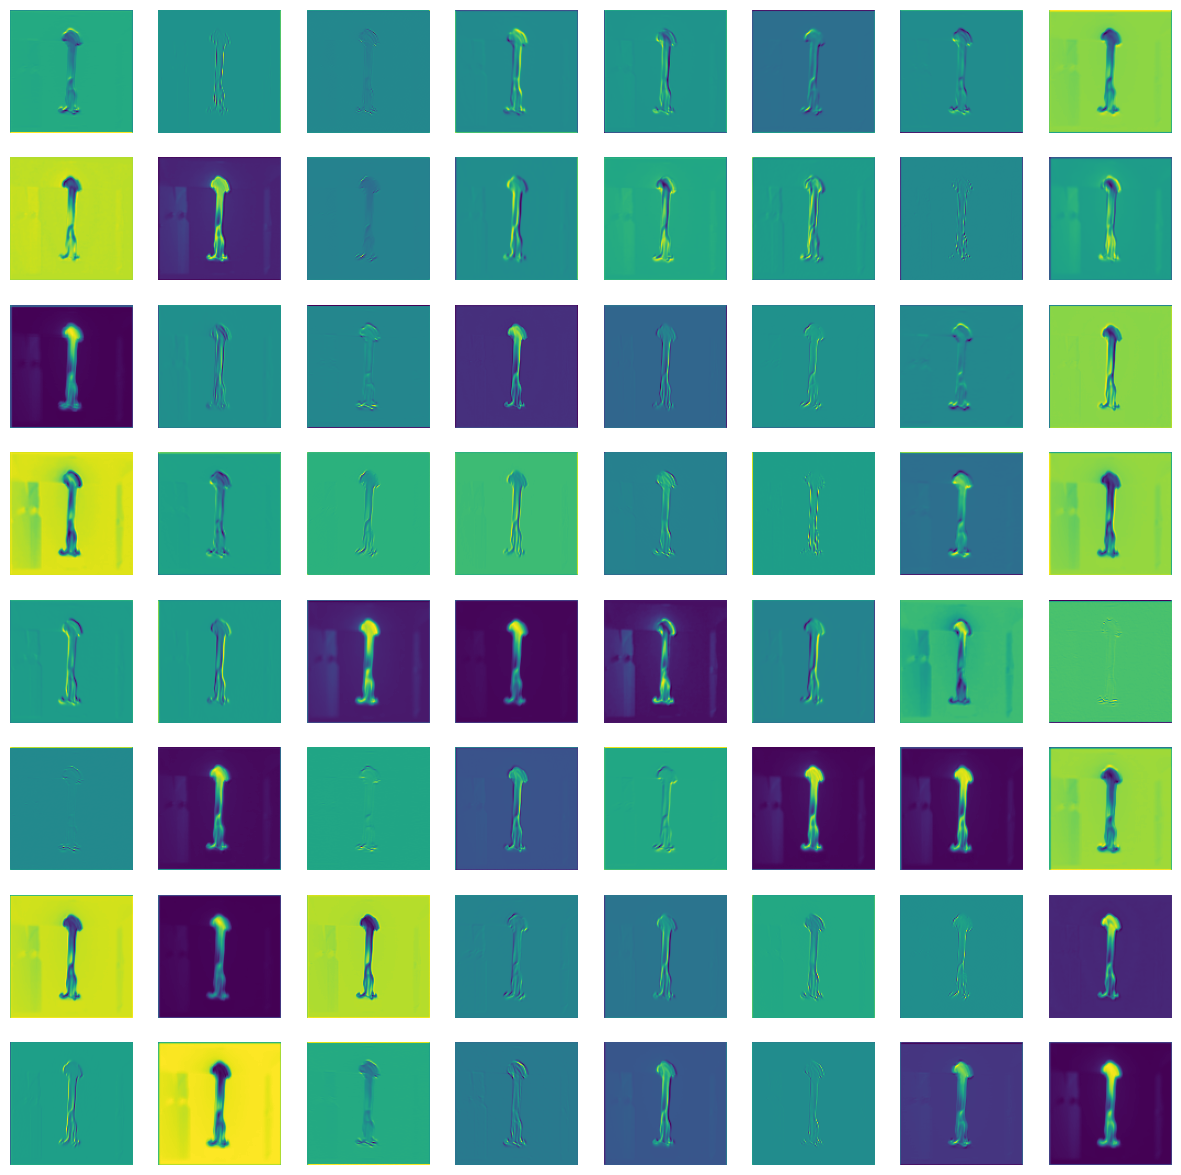

In [260]:
def visualize_hook(module, input, output):
    plt.figure(figsize=(15, 15))  # Set the figure size for visualization
    print("Output shape:", output.shape)
    for i in range(output.size(1)):  # Iterate over all filters (Cout)
        plt.subplot(8, 8, i + 1)  # Adjust the grid size based on the number of filters
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="viridis")  # Plot each filter's output
        plt.axis("off")  # Turn off axis
    plt.show()

def run_single_layer_visualization(dataloader, mymodel):
    # Register hooks for each layer and visualize
    tr_img, tr_label = next(iter(dataloader))
    image = tr_img[0].unsqueeze(0)  
    
    layer_to_visualize = mymodel.conv1  
    hook = layer_to_visualize.register_forward_hook(visualize_hook)
    # Pass the image through the model
    mymodel.eval()
    with torch.no_grad():
        mymodel(image)
    
    hook.remove()

run_single_layer_visualization(train_loader, model)

### Fine Tune on Testing dataset

In [230]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
import seaborn as sn

In [227]:
def evaluate(dataloader, mymodel):
    """Trained model evaluates on the entire testing data"""
    mymodel.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = mymodel(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy, all_labels, all_preds

In [228]:
fine_tuned_model = model
fine_tuned_test_accuracy, test_labels, fine_tuned_test_preds = evaluate(test_loader, fine_tuned_model)
conf_matrix = confusion_matrix(test_labels, fine_tuned_test_preds)

### Confusion Matrix for fine tuned model on testing dataset

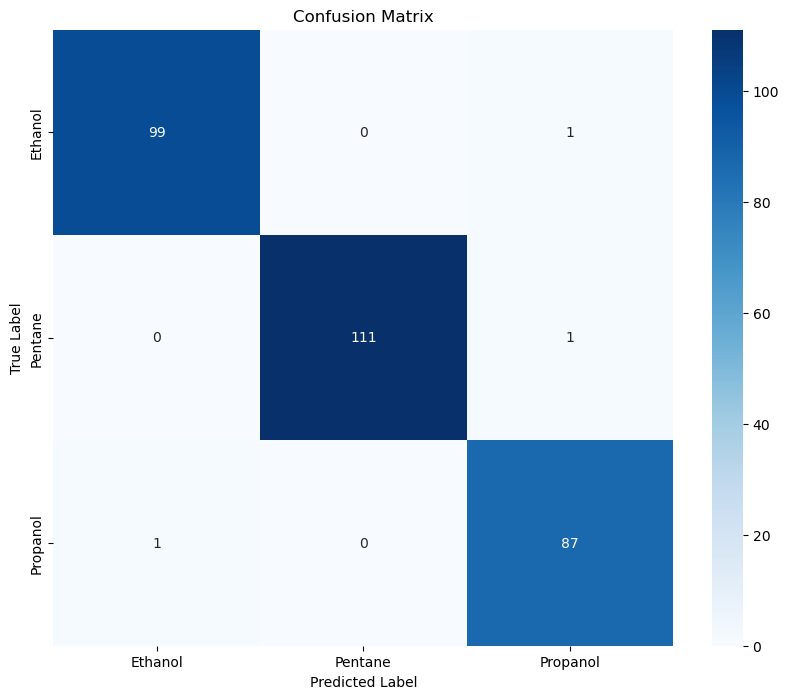

In [231]:
plt.figure(figsize=(10, 8))
sn.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Comparison with Baseline Model

In [237]:
# For Baseline Model (Vanilla Pretrained ResNet-34)
baseline_model = resnet34(pretrained=True)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, num_classes)  # Same output layer

In [238]:
baseline_accuracy, _, baseline_preds = evaluate(test_loader, baseline_model)

print(f"Fine-Tuned Model Accuracy: {fine_tuned_test_accuracy:.4f}")
print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")

Fine-Tuned Model Accuracy: 0.9900
Baseline Model Accuracy: 0.2567


### Precision-Recall Curve

In [253]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

In [254]:
num_classes = len(classes)
model.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in test_loader:  
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)  

y_true = label_binarize(test_labels, classes=list(range(num_classes)))  

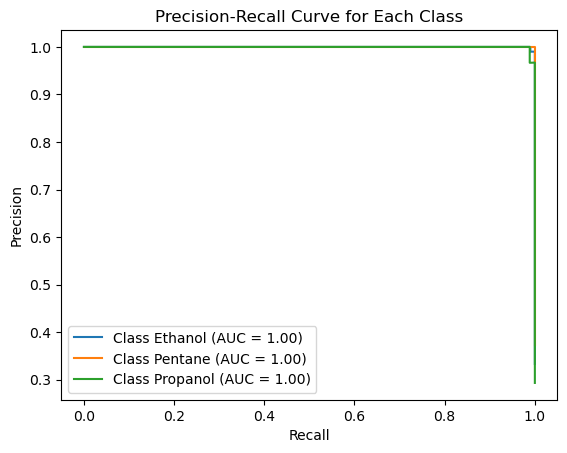

In [257]:
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    
    plt.plot(recall, precision, label=f"Class {class_name} (AUC = {auc_score:.2f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

### Comments
- Trained the resnet model on burning liquid dataset 3x on conditions such as:
  1) Unfreezing fc layer only with 15 epochs & lr = 1e-4
  2) Unfreezing layer4 & fc layer with 10 epochs & lr = 1e-5
  3) Unfreezing layer3, layer4 & fc with & lr = 1e-6
- Observed accuracy & learning curvers are reaching plateaus in just fewer epochs only when we unfreeze more layers
- Compared to baseline, fine-tuned model with unfreezing layers is achieving better accuracy
- Fine-tuned model gives AUC=1 i.e able to make correct predictions